
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/79_Vector_Compression_Product_Quantization.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🗜️ Product Quantization (PQ): Jak zmieścić miliard wektorów w RAM?

Standardowy wektor z OpenAI ma 1536 wymiarów. Każda liczba to `float32` (4 bajty).
Jeden wektor = 6 KB.
Miliard wektorów = **6 TB RAM**. To kosztuje fortunę.

**Product Quantization** to metoda stratnej kompresji wektorów.

**Algorytm:**
1.  **Podział (Split):** Dzielimy długi wektor (np. 128D) na 8 krótkich kawałków (po 16D).
2.  **Klastrowanie (Train):** Dla każdego kawałka uczymy osobny algorytm K-Means (tworzymy "Książkę Kodów").
3.  **Kodowanie (Encode):** Zamiast zapisywać liczby, zapisujemy tylko **ID klastra**, do którego pasuje dany kawałek.

Efekt? Zamiast 128 liczb float, mamy 8 liczb int (bajtów).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# 1. GENERUJEMY DANE (Wysoki wymiar)
# Symulacja embeddingów (np. 10 000 dokumentów, każdy ma 128 cech)
N_VECTORS = 10_000
DIM = 128

np.random.seed(42)
data = np.random.random((N_VECTORS, DIM)).astype(np.float32)

# Sprawdźmy rozmiar w pamięci
original_size_mb = data.nbytes / 1024 / 1024
print(f"Dane oryginalne: {data.shape}")
print(f"Rozmiar w RAM: {original_size_mb:.2f} MB")

Dane oryginalne: (10000, 128)
Rozmiar w RAM: 4.88 MB


## Trening PQ (Tworzenie Codebooka)

Podzielimy wektor 128D na **8 podprzestrzeni (sub-spaces)** po 16D każda.
Dla każdej podprzestrzeni wytrenujemy `K-Means` z 256 centrami (klastrami).

Dlaczego 256? Bo 256 to $2^8$. Każdy ID klastra zmieści się w **jednym bajcie** (`uint8`).

In [2]:
# Konfiguracja PQ
M = 8  # Na ile kawałków dzielimy wektor? (128 / 8 = 16 wymiarów na kawałek)
SUB_DIM = DIM // M
K = 256 # Ile centrów w każdym kawałku? (mieści się w 1 bajcie)

# Tablica na nasze modele K-Means (Codebooks)
codebooks = []

print(f"Dzielimy wektor 128D na {M} kawałków po {SUB_DIM}D.")
print("Trenowanie K-Means dla każdego kawałka...")

for m in range(M):
    # Wyciągamy m-ty kawałek ze wszystkich danych
    # slicing: wszystkie wiersze, kolumny od m*sub_dim do (m+1)*sub_dim
    sub_data = data[:, m*SUB_DIM : (m+1)*SUB_DIM]
    
    # Trenujemy K-Means
    kmeans = KMeans(n_clusters=K, n_init=3, random_state=42)
    kmeans.fit(sub_data)
    
    # Zapisujemy centra (to jest nasz "słownik")
    codebooks.append(kmeans.cluster_centers_)
    
    if m % 2 == 0:
        print(f"  -> Wytrenowano podprzestrzeń {m+1}/{M}")

print("✅ Codebook gotowy.")

Dzielimy wektor 128D na 8 kawałków po 16D.
Trenowanie K-Means dla każdego kawałka...
  -> Wytrenowano podprzestrzeń 1/8
  -> Wytrenowano podprzestrzeń 3/8
  -> Wytrenowano podprzestrzeń 5/8
  -> Wytrenowano podprzestrzeń 7/8
✅ Codebook gotowy.


## Kodowanie (Kompresja)

Teraz zamienimy nasze wielkie wektory na małe kody.
Dla każdego kawałka wektora szukamy najbliższego centrum w Codebooku i zapisujemy tylko jego **indeks**.

In [3]:
def encode_pq(vectors, codebooks):
    n_samples = vectors.shape[0]
    m_chunks = len(codebooks)
    sub_dim = vectors.shape[1] // m_chunks
    
    # Wynikowa macierz skompresowana (typu uint8 - 1 bajt!)
    codes = np.zeros((n_samples, m_chunks), dtype=np.uint8)
    
    for m in range(m_chunks):
        sub_vectors = vectors[:, m*sub_dim : (m+1)*sub_dim]
        centroids = codebooks[m]
        
        # Szukamy najbliższego centroidu dla każdego wektora
        # (W prawdziwym FAISS to jest zoptymalizowane w C++, tu robimy brute-force w numpy)
        # Obliczamy dystanse: ||x - c||^2
        
        # Dla każdego wektora liczymy odległość do 256 centroidów
        # Używamy tricku z broadcastingiem, żeby nie robić pętli po wektorach
        # Ale dla czytelności zróbmy prosto: użyjmy predict z K-Means (choć wolne)
        
        # Szybsza metoda matematyczna (L2 distance):
        # dystans = sqrt(sum((x - c)^2))
        dists = np.linalg.norm(sub_vectors[:, None, :] - centroids[None, :, :], axis=2)
        
        # Wybieramy indeks najmniejszego dystansu
        codes[:, m] = np.argmin(dists, axis=1)
        
    return codes

print("Kompresowanie danych...")
compressed_data = encode_pq(data, codebooks)

print(f"Wymiar skompresowany: {compressed_data.shape}")
print(f"Typ danych: {compressed_data.dtype}")

# Porównanie rozmiaru
compressed_size_mb = compressed_data.nbytes / 1024 / 1024
ratio = original_size_mb / compressed_size_mb

print("-" * 30)
print(f"Rozmiar Oryginału: {original_size_mb:.2f} MB")
print(f"Rozmiar PQ:        {compressed_size_mb:.2f} MB")
print(f"🚀 Kompresja: {ratio:.1f}x mniejszy!")

Kompresowanie danych...
Wymiar skompresowany: (10000, 8)
Typ danych: uint8
------------------------------
Rozmiar Oryginału: 4.88 MB
Rozmiar PQ:        0.08 MB
🚀 Kompresja: 64.0x mniejszy!


## Dekodowanie (Rekonstrukcja) i Błąd

Wektory PQ są stratne. Nie odzyskamy idealnie oryginału.
Odzyskujemy **przybliżenie** – zamiast prawdziwego wektora, wstawiamy w jego miejsce centroid (wzorzec).

Sprawdźmy, jak duży jest błąd.

Błąd rekonstrukcji (MSE): 0.041142


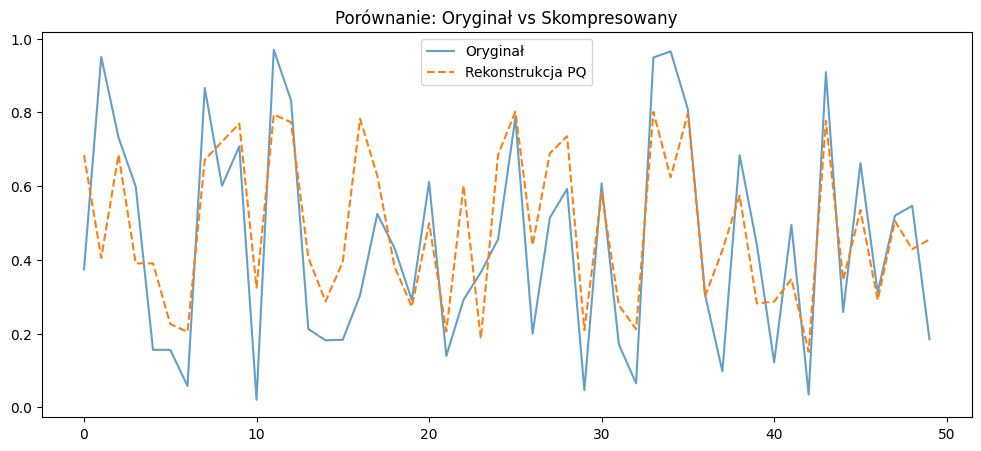

In [4]:
def decode_pq(codes, codebooks):
    n_samples, m_chunks = codes.shape
    # Pobieramy wymiar z codebooka
    sub_dim = codebooks[0].shape[1]
    dim = m_chunks * sub_dim
    
    reconstructed = np.zeros((n_samples, dim), dtype=np.float32)
    
    for m in range(m_chunks):
        # Bierzemy indeksy dla danego kawałka
        indices = codes[:, m]
        # Wyciągamy odpowiadające im centroidy
        reconstructed[:, m*sub_dim : (m+1)*sub_dim] = codebooks[m][indices]
        
    return reconstructed

# Odtwarzamy
reconstructed_data = decode_pq(compressed_data, codebooks)

# Liczymy błąd (MSE)
mse = mean_squared_error(data, reconstructed_data)
print(f"Błąd rekonstrukcji (MSE): {mse:.6f}")

# Wizualizacja: Oryginał vs PQ (Pierwsze 50 wymiarów jednego wektora)
plt.figure(figsize=(12, 5))
plt.plot(data[0, :50], label="Oryginał", alpha=0.7)
plt.plot(reconstructed_data[0, :50], label="Rekonstrukcja PQ", linestyle="--")
plt.title("Porównanie: Oryginał vs Skompresowany")
plt.legend()
plt.show()

## 🧠 Podsumowanie: IVFPQ

To, co zrobiliśmy (PQ), jest fundamentem najpopularniejszego indeksu w bazach wektorowych: **IVFPQ** (Inverted File + Product Quantization).

1.  **IVF (Inverted File):** Dzieli przestrzeń na komórki (jak HNSW czy Voronoi), żeby nie przeszukiwać wszystkiego.
2.  **PQ (Product Quantization):** Kompresuje wektory wewnątrz komórek, żeby zmieściły się w RAM.

**Efekt:**
Możesz przeszukiwać miliard wektorów na jednym serwerze w milisekundy.
Wykres pokazuje, że rekonstrukcja nie jest idealna, ale "kształt" wektora jest zachowany wystarczająco dobrze, by Cosine Similarity nadal wskazywało poprawne dokumenty w RAG.